# Data Component Use Case for Landslide Susceptibility Calculation

## Introduction

Landslide susceptibility is the likelihood of a landslide occurring in an area on the basis of local terrain condition to estimate “where” landslides are likely to occur. This Jupyter notebook demonstrates how to use several [CSDMS data components](https://csdms.colorado.edu/wiki/DataComponents) to download topography and soil datasets to calculate the landslide susceptibility for a study area in Puerto Rico. 

In this notebook, it includes the following sections:
- [Initial Setup](#setup)
  
  This section will help install several Python packages and create the input/output folders.
  <br>
- [Step1: Download Datasets](#step1) 

  This section will download the topography and soil datasets.
  <br>
- [Step2: Regrid Datasets](#step2)

  This section will regrid the datasets in the same grid resolution. 
  <br>
- [Step3: Calculate Susceptibility](#step3)

  This section will use the datasets to calculate the landslide susceptibility.
  <br>
- [Step4: Visualize Results](#step4)

  This section will visualize the final results as a short video.
  <br>
  
**Run Notebook**: You can test and run this Jupyter Notebook through [HydroShare](https://www.hydroshare.org/resource/df5fa2f5d1b74be4bf0a049e1e59889c/). If you have any suggestion to improve this notebook, please create a Github issue [here](https://github.com/gantian127/landslide).

**Suggested Citation**: Gan, T., Campfort B., Tucker, G. E., Overeem I. (2022). Data Component Use Case for Landslide Susceptibility Calculation, HydroShare, https://www.hydroshare.org/resource/df5fa2f5d1b74be4bf0a049e1e59889c/

<a id='setup'></a>
## Initial Setup

We will install the following packages for this notebook. There are two installation options that you can choose based on whether you will run the notebook on your local PC or in HydroShare. After you install the packages, you will need to run a helper function to create API Key files for the ERA5 and Topography data components.
- pymt
- cdsapi
- pymt-era5
- pymt-topography
- numpy
- xesmf
- xarray
- rioxarray
- cftime
- imageio
- ffmpeg
- matplotlib

### Install Packages (on CUAHSI JupyterHub)

If you access this notebook from [HydroShare](https://www.hydroshare.org/resource/df5fa2f5d1b74be4bf0a049e1e59889c/) and run it on the CUAHSI JupyterHub, please run the command below to install the required packages.

In [ ]:
! conda install --file=requirements.txt
! pip install pymt-era5

### Install Packages (on Local PC)
If you want to run this notebook on your PC, you can run the following command which will create a separate conda environment named "landslide" and install all the required packages for you. After the installation, please make sure to activate the environment to run this notebook.

In [ ]:
! conda env create --file=environment.yml

### Install API key files
For the ERA5 and Topography data components, there is a need to create API key files to download the datasets. The install_api_key( ) function will ask for your [CDS API Key](https://cds.climate.copernicus.eu/api-how-to) and [Open Topography API Key](https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets) to create API key files. Please make sure you have already obtained those API Keys before you run this helper function. 


In [1]:
from utils import install_api_key
install_api_key()

Enter Your OpenTopography API Key: 3ba4e008b21baeb2abd066c5b0fb0412
OpenTopography API Key file is created at /Users/jamy/.opentopography.txt.
Enter Your CDS API Key: 94367:14201e13-9c49-4962-87c1-1613f91b9b6a
CDS API Key file is created at /Users/jamy/.cdsapirc


### Create folders
We will create three folders for this notebook:
- **configuration file folder**: this folder includes several configuration files which will be used by the data components. In this example, we have prepared these configuration files and put them in this folder. 
- **cache folder**: this folder stores the downloaded data files.
- **results folder**: this folder stores the final results.

In [2]:
import os

study_area = 'puerto_rico'

config_dir = os.path.join(os.getcwd(), 'config_files_{}'.format(study_area)) # put config file in it
results_dir = os.path.join(os.getcwd(), 'results_{}'.format(study_area)) # create a folder
cache_dir = os.path.join(os.getcwd(),'cache_{}'.format(study_area))


for folder in [config_dir, results_dir, cache_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(folder)

<a id='step1'></a>
## Step 1 Download Datasets

### Background 

Hurricane Maria hit the island of Puerto Rico on September 20th, 2017 and triggered thousands of landslides in many places of Puerto Rico (see details [here](https://www.usgs.gov/supplemental-appropriations-for-disaster-recovery-activities/landslides-triggered-hurricane-maria)). In this use case, we will calculate the hourly landslide susceptibility in a mountainous area of Puerto Rico. We will prepare the following datasets to calculate the landslide susceptibility. Details for how to calculate the landslide susceptbility is described in [Step 3](#step3)
- OpenTopography DEM 
- ERA5 volumetric soil water and precipitation 
- Soil depth  
- Slope angle

### OpenTopography DEM 

We will use the [Topography data component](https://csdms.colorado.edu/wiki/Model:Topography_Data_Component) to download the Digital Elevation Model (DEM) data with 90m resolution. The 'dem_config.yaml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to initialize a data component and how to use the variable and grid related methods of this data component to get the metadata as well as the data values.

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from pymt.models import Topography

In [4]:
# initialize Topography data component
dem = Topography()
dem.initialize(os.path.join(config_dir, 'dem_config.yaml'))

In [5]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: meters 
var_location: node 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 864000 



In [6]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [ 360 1200] 
grid_spacing: [ 0.00083333  0.00083333] 
grid_origin: [ 18.02083333 -67.13      ]


Text(0.5, 1.0, 'DEM data (m)')

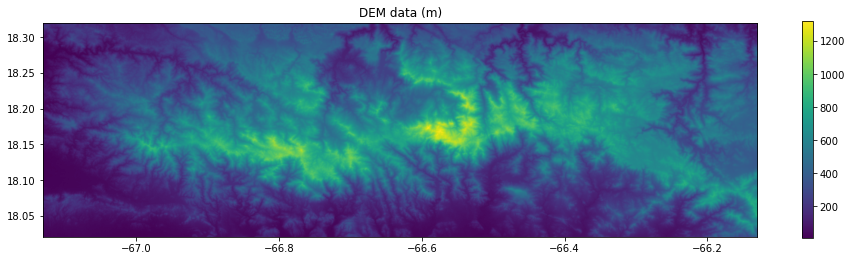

In [7]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1, figsize=(16,4))
im = ax.imshow(dem_data_2D, extent=extent)
ax.title.set_text('DEM data (m)')
fig.colorbar(im)
ax.title

### ERA5 Volumetric Soil Water & Precipitation 
We will use the [ERA5 data component](https://csdms.colorado.edu/wiki/Model:ERA5_Data_Component) to download the hourly volumetric soil water data and the precipitation data of the study area with 0.25 degrees (27-28km) resolution. The volumetric soil water data will be used for calculating the susceptbility, while the precipitation data is mainly used for results visualization. 

The 'era5_config.yaml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to initialize an ERA5 data component and how to use the variable, grid and time related methods to get the metadata as well as the data values. You'll notice that although the ERA5 and Topography data components download the datasets from different sources, they are using the same methods to get information from the datasets.

In [8]:
from pymt.models import Era5

# initialize ERA5 data component
era5 = Era5()
era5.initialize(os.path.join(config_dir,'era5_config.yaml'))

2022-02-10 14:05:26,825 INFO Welcome to the CDS
2022-02-10 14:05:26,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2022-02-10 14:05:27,318 INFO Request is completed
2022-02-10 14:05:27,319 INFO Downloading https://download-0012.copernicus-climate.eu/cache-compute-0012/cache/data3/adaptor.mars.internal-1644438445.3490655-5460-11-87bf2dc5-e65a-4fe1-8310-8aca441c3be8.nc to ./cache_puerto_rico/era5.nc (28.3K)
2022-02-10 14:05:28,740 INFO Download rate 19.9K/s                              


In [9]:
# get ERA5 variable info
for var_name in era5.output_var_names:
    var_unit = era5.var_units(var_name)
    var_location = era5.var_location(var_name)
    var_type = era5.var_type(var_name)
    var_grid = era5.var_grid(var_name)
    var_itemsize = era5.var_itemsize(var_name)
    var_nbytes = era5.var_nbytes(var_name)
    print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: Total precipitation 
var_unit: m 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 24 

variable_name: Volumetric soil water layer 1 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 24 

variable_name: Volumetric soil water layer 2 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 24 

variable_name: Volumetric soil water layer 3 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 24 

variable_name: Volumetric soil water layer 4 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 24 



In [10]:
# get ERA5 grid info
era5_grid_ndim = era5.grid_ndim(var_grid) 
era5_grid_type = era5.grid_type(var_grid)
era5_grid_shape = era5.grid_shape(var_grid)
era5_grid_spacing = era5.grid_spacing(var_grid)
era5_grid_origin = era5.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    era5_grid_ndim, era5_grid_type, era5_grid_shape, era5_grid_spacing, era5_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [2 6] 
grid_spacing: [ 0.25  0.25] 
grid_origin: [ 18.   -67.25]


In [11]:
# get ERA5 time info
era5_start_time = era5.start_time
era5_end_time = era5.end_time
era5_time_step = era5.time_step
era5_time_unit = era5.time_units
era5_time_steps = int((era5_end_time - era5_start_time)/era5_time_step) + 1

print('start_time:{} \nend_time:{} \ntime_step:{} \ntime_unit:{} \ntime_steps:{}'.format(
    era5_start_time, era5_end_time, era5_time_step, era5_time_unit, era5_time_steps))

start_time:1031880.0 
end_time:1032095.0 
time_step:1.0 
time_unit:hours since 1900-01-01 00:00:00.0 
time_steps:216


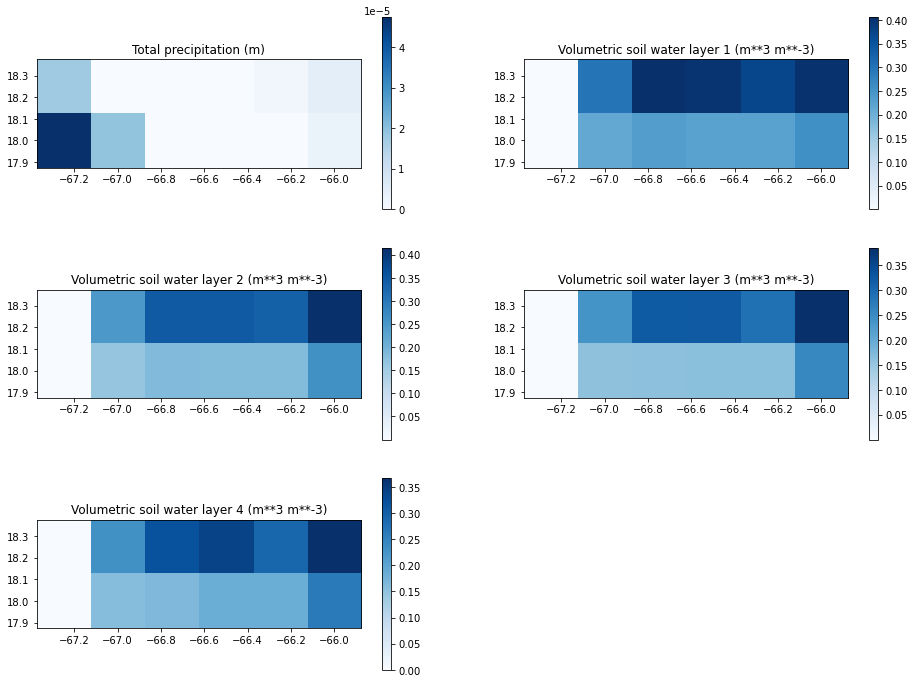

In [12]:
# get ERA5 variables data and plot (for the first time step)
fig = plt.figure(figsize=(16,12)) 
nrows, ncols = 3, 2
i = 1

for var_name in era5.output_var_names:
    ax = fig.add_subplot(nrows, ncols, i)
    var_unit = era5.var_units(var_name)
    
    # get variable data    
    era5_data = era5.get_value(var_name)
    era5_data_2D = era5_data.reshape(era5_grid_shape)
    
    # get X, Y extent for plot
    min_y, min_x = era5_grid_origin
    max_y = min_y + era5_grid_spacing[0]*(era5_grid_shape[0]-1)
    max_x = min_x + era5_grid_spacing[1]*(era5_grid_shape[1]-1)
    dy = era5_grid_spacing[0]/2
    dx = era5_grid_spacing[1]/2
    extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

    # plot data
    im = ax.imshow(era5_data_2D, extent=extent, cmap='Blues')
    ax.title.set_text('{} ({})'.format(var_name,var_unit ))
    cbar = plt.colorbar(im, ax=ax)
    
    i += 1

### Soil Depth data

Since the data component for soil depth data is not available yet, we will use the xarray and rioxarray to subset and download the soil depth data with 250m resolution from [SoilGrids](https://www.isric.org/explore/soilgrids) system. In this dataset, the maximum soil depth value is 200cm. Grid with values larger than 200cm represents open water area. 

In [13]:
import rioxarray 
import xarray

# download and subset soil depth data
soil_raster = xarray.open_rasterio("https://files.isric.org/soilgrids/former/2017-03-10/data/BDRICM_M_250m_ll.tif")
soil_depth_data = soil_raster.rio.clip_box(
    minx=-67.13,
    miny=18.02,
    maxx=-66.13,
    maxy=18.32,
)

/var/folders/y6/lbz3kd1d32v5z0zj158yv_zr0000gn/T/ipykernel_70014/1416209778.py:5: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  soil_raster = xarray.open_rasterio("https://files.isric.org/soilgrids/former/2017-03-10/data/BDRICM_M_250m_ll.tif")
Warning 1: +init=epsg:XXXX syntax is deprecated. It might return a CRS with a non-EPSG compliant axis order.


Text(0.5, 1.0, 'Soil Depth (cm)')

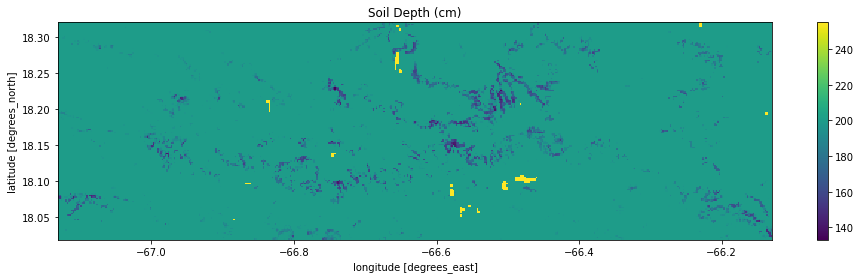

In [14]:
# plot soil depth data
soil_depth_data.plot(figsize=(16,4))
soil_depth_data.rio.to_raster(os.path.join(cache_dir,'soil_depth.tif'))
plt.title('Soil Depth (cm)')

### Slope angle

Slope angle is one of the input for calculating the landslide susceptibility. In this example, we will use the Topography data and the [RasterModelGrid](https://landlab.readthedocs.io/en/master/reference/grid/raster.html) from [Landlab](https://landlab.readthedocs.io/en/master/index.html) to calculate the slope angle for the study area. 

In [15]:
from landlab import RasterModelGrid

# calculate slope angle using Topography data
model_grid = RasterModelGrid(dem_data_2D.shape,xy_spacing=(90,90))
slope = model_grid.calc_slope_at_node(elevs=dem_data) # slope in magintude, 1D array
slope_angle = slope.reshape(dem_data_2D.shape) # reshape as 2D array

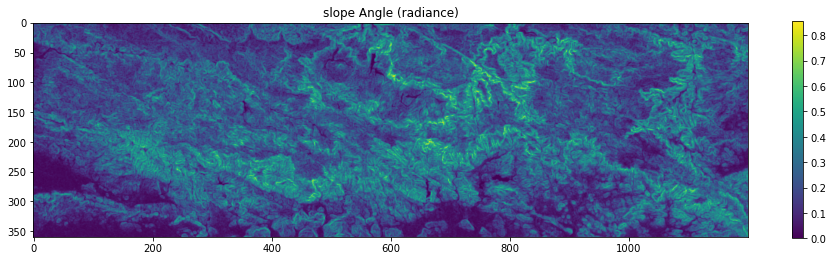

In [16]:
# plot slope angle
fig, ax = plt.subplots(figsize=(16,4))
im=ax.imshow(slope_angle)
cbar = fig.colorbar(im)
ax.title.set_text('slope Angle (radiance)')

<a id='step2'></a>
## Step 2 Regrid datasets

Before the calculation of the landslide susceptbility, we need to regrid all the datasets in the same grid resolution. We will take the Topography dataset as the template to regrid the soil depth data in a higher resolution. In this example, we will use the regrid_data( ) function for regridding purpose.

The ERA5 dataset will also need to be regridded. However, since it is a multidimentional space time data, we will regrid ERA5 data with similar method in a for loop in [Step3](#step3)

In [17]:
import xarray
import xesmf as xe

from utils import regrid_data

# define destination grid coordinate using Topography data
dem_y = np.flip(np.arange(dem_grid_shape[0])*dem_grid_spacing[0] + dem_grid_origin[0])
dem_x = np.arange(dem_grid_shape[1])*dem_grid_spacing[1] + dem_grid_origin[1]
dest_coor = {'lon': dem_x, 
             'lat': dem_y}

In [18]:
# regrid soil depth data
soil_depth_coor = {'lon': soil_depth_data.x.values,
                   'lat': soil_depth_data.y.values}

soil_depth = regrid_data(soil_depth_data.values[0], soil_depth_coor, dest_coor) 
soil_depth = soil_depth/100 # units conversion as m

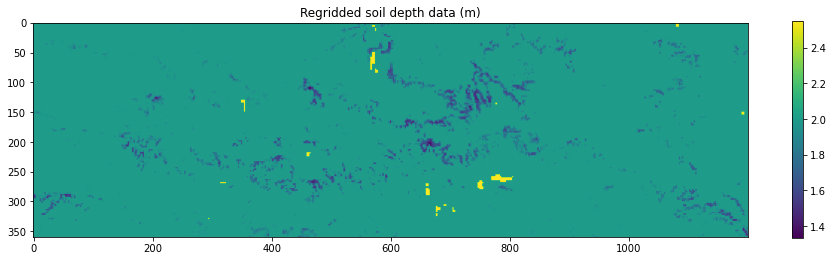

In [20]:
# plot result
fig, ax = plt.subplots(1,1,figsize=(16,4))
im = ax.imshow(soil_depth)
ax.title.set_text('Regridded soil depth data (m)')
cbar = plt.colorbar(im)

<a id='step3'></a>
## Step 3  Calculate Susceptibility

This section will loop through each time step to calculate the hourly landslide susceptibility, which mainly includes the following tasks:
- Regrid ERA5 datasets
- Calculate subsurface flow depth
- Calculate factor of safety
- Calculate susceptibility
- Plot results


**Regrid ERA5 datasets**

The ERA5 precipitation and volumetric soil water datasets will be regridded in a higher resolution by using the Topography dataset as the template. The regrid_data( ) function will be used which is similar as the code shown in [Step2](#step2). As mentioned before, the volumetric soil water data is used for calculation and the precipitation data is mainly used to visualize the rainfall change during the time period. 

**Subsurface flow depth** 

The subsurface flow depth is calculated using the soil depth data and the ERA5 volumetric soil water datasets. There are four layers of the ERA5 volumetric soil water data (Layer 1: 0 - 7cm, Layer 2: 7 - 28cm, Layer 3: 28 - 100cm, Layer 4: 100 - 289cm). The cal_subsurface_flow_depth( ) function is used for calculation.

**Factor of safety**

In geological engineering, it is common to take the ratio of the resisting stresses to driving stresses. This ratio is called the factor of safety (FS). When FS is larger than 1, the slope should be stable, while if it is below 1, the driving stress exceeds the resistance and the slope is likely to fail. FS can be calculated with the following function, and cal_safety_factor( ) is implemented based on this function.

$$
FS = \frac{(C_r + C_s)/h_s\rho_sg}{sin\theta} + \frac{cos\theta tan\phi (1-\frac{h_w}{h_s}\rho_w / \rho_s)}{sin\theta}
$$

where, 
- Cr: root cohesion (Pa kg/ms^2)
- Cs: soil cohesion (Pa kg/ms^2)
- hs: soil depth (m)
- hw: subsurface flow depth (m)
- ρs: soil density (kg/m^3)
- ρw: water desity (kg/m^3)
- g: gravity acceleraition (m/s^2)
- θ: slope angle 
- φ: soil internal fricition angle

**Susceptibility**

Susceptibility is the inverse of FS. When the susceptbility is larger than 1, it means that the slope of area is not stable and susceptible to landslide.  

$$
Susceptibility = \frac{1}{FS}
$$


**Plot Results**

At each time step, it makes four plots. The first plot is the landslide susceptibility at current time step. The second plot is the difference of the landslide susceptibility between the current and the last step. The third plot is the difference of the subsurface flow depth between the current and the last step. The fourth plot is the precipitation at the current time step. Please note that at the first time step, the second plot will not be applicable and the third plot will show the subsurface flow depth result.

In [21]:
import cftime
from datetime import datetime
from matplotlib import colors

from utils import cal_subsurface_flow_depth, cal_safety_factor


# define ERA5 input coor
era5_y = np.flip(np.arange(era5_grid_shape[0])*era5_grid_spacing[0] + era5_grid_origin[0])
era5_x = np.arange(era5_grid_shape[1])*era5_grid_spacing[1] + era5_grid_origin[1]
era5_coor = {'lon': era5_x, 
             'lat': era5_y}

soil_water_layer = np.empty([4,*dem_grid_shape], dtype=era5.var_type('Volumetric soil water layer 1'))

# define mask
mask = (slope_angle==0)&(soil_depth>2.0)


# timing
print(datetime.now())

# calculation and plot
for time_step in range(0, 5): 
    time = cftime.num2date(era5.time, era5_time_unit, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
    print(time_step,time)
     
    # regrid era5 precipitation 
    era5_prec = era5.get_value('Total precipitation')
    era5_prec_2D = era5_prec.reshape(era5_grid_shape)
    era5_prec_data = regrid_data(era5_prec_2D, era5_coor, dest_coor)
    
    # regrid era5 volumetirc soil water
    for i in range(0,4):
        var_name = 'Volumetric soil water layer {}'.format(i+1)

        # get original data
        era5_soil_water = era5.get_value(var_name)
        era5_soil_water_2D = era5_soil_water.reshape(era5_grid_shape)

        # regrid
        soil_water_layer[i] = regrid_data(era5_soil_water_2D, era5_coor, dest_coor)
       
    # calculate subsurface_flow_depth
    subsurface_flow_depth = cal_subsurface_flow_depth(soil_depth, soil_water_layer)
    
    # caculate safety factor
    safety_factor = cal_safety_factor(slope_angle, subsurface_flow_depth, soil_depth, 
                                      root_cohesion=5000, soil_cohesion=5000, soil_bulk_density=1300,
                                      soil_internal_friction_angle=35)
    
    # calculate susceptibility
    susceptibility = 1.0 / safety_factor
    susceptibility = np.where(~mask, susceptibility, np.nan)
       
    
    # plot susceptibility
    fig = plt.figure(figsize=(16,15))
    plt.rcParams["figure.autolayout"] = True
    #fig.suptitle('Results at {}'.format(time))
    
    nrows, ncols = 4,1
    ax_sus = fig.add_subplot(nrows, ncols, 1)
    ax_diff = fig.add_subplot(nrows, ncols, 2)
    ax_prcp = fig.add_subplot(nrows, ncols, 4)
    ax_soil = fig.add_subplot(nrows, ncols, 3)
    

    # sus plot 
    divnorm=colors.TwoSlopeNorm(vcenter=1.0)
    im_sus=ax_sus.imshow(susceptibility, cmap='BrBG_r', norm=divnorm)
    fig.colorbar(im_sus, ax=ax_sus)
    ax_sus.title.set_text('Susceptibility of landslide at {}'.format(time))
    
    # sus diff plot
    if time_step >0:
        diff2 = susceptibility - reference2      
        
        divnorm=colors.TwoSlopeNorm(vcenter=0.0)       
        im_diff=ax_diff.imshow(diff2, cmap='BrBG_r', norm=divnorm)
        fig.colorbar(im_diff, ax=ax_diff)
        ax_diff.title.set_text('Difference of susceptibility')
    else:
        ax_diff.axis('off')
        
    reference2 = np.copy(susceptibility)  
    
    # prcp plot
    vmax = None if era5_prec_data.max() != 0 else 0.0001   
    im_prcp = ax_prcp.imshow(era5_prec_data, cmap='Blues',vmin=0.0,vmax=vmax)
    fig.colorbar(im_prcp, ax=ax_prcp)
    ax_prcp.title.set_text('Precipitation (m)')
    
    # soil water plot
    if time_step==0:
        im_data = subsurface_flow_depth
        ax_soil.title.set_text('Subsurface flow depth')
    else:
        im_data = subsurface_flow_depth - reference3
        ax_soil.title.set_text('Difference of subsurface flow depth')
        
    divnorm=colors.TwoSlopeNorm(vcenter=0.0) 
    im_soil = ax_soil.imshow(im_data, cmap='RdBu', norm=divnorm)
    fig.colorbar(im_soil, ax=ax_soil)
    
    reference3 = np.copy(subsurface_flow_depth)   
        
    # save plot    
    plt.close(fig)
    fig.savefig(os.path.join(results_dir, 'sus_{}.png'.format(time_step)))
    
    # update time step
    era5.update()
    

print(datetime.now())

print('calculation is done')

2022-02-10 14:08:19.041363
0 2017-09-19 00:00:00
1 2017-09-19 01:00:00
2 2017-09-19 02:00:00
3 2017-09-19 03:00:00
4 2017-09-19 04:00:00
2022-02-10 14:11:46.667695
calculation is done


<a id='step4'></a>
## Step 4 Visualize Results

Run the cells below and it will show a short video. You'll find that when the subsurface flow depth increases (blue color), the land susceptibility increase (brown color). When the subsurface flow depth decreases (red color), the land susceptbility decreases (green color). 

In [23]:
import imageio
import os


# Make short video
files_list = sorted(os.listdir(results_dir))

for var in ['sus']:
    files = [file for file in files_list if var in file ]
    
    with imageio.get_writer(os.path.join(results_dir,'{}.mp4'.format(var)), mode='I', fps=1) as writer:
        for f in files:
            if '.png' in f:
                im = imageio.imread(os.path.join(results_dir, f))
                writer.append_data(im)

    writer.close()

2022-02-10 14:13:28,473 WARNING IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1152, 1080) to (1152, 1088) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[rawvideo @ 0x7fa058800000] Stream #0: not enough frames to estimate rate; consider increasing probesize


 <video controls src="./results_puerto_rico/sus.mp4" />

## References
- Strauch, R., Istanbulluoglu, E., Nudurupati, S. S., Bandaragoda, C., Gasparini, N. M., and Tucker, G. E. (2018), A hydroclimatological approach to predicting regional landslide probability using Landlab, Earth Surf. Dynam., 6, 49–75, https://doi.org/10.5194/esurf-6-49-2018
- Montgomery, D. R., and Dietrich, W. E. (1994), A physically based model for the topographic control on shallow landsliding, Water Resour. Res., 30( 4), 1153– 1171, doi:10.1029/93WR02979.